In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import sys
import missingno as msno
import torch
from torch import nn
from pathlib import Path
import morethemes as mt

In [3]:
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / "data"

In [4]:
df = pd.read_csv(DATA_DIR / "sdwpf_2001_2112_full.csv", nrows=3000000)
turb_loc_df = pd.read_csv(DATA_DIR / "sdwpf_turb_location_elevation.csv")

In [16]:
df.describe(include=(np.number))

,TurbID,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,T2m,Sp,RelH,Wspd_w,Wdir_w,Tp,Patv
count,3.000000e+06,2.903596e+06,2.903596e+06,2.903596e+06,2.903596e+06,2.903596e+06,2.903596e+06,2.903596e+06,2.903596e+06,2.903596e+06,2.997008e+06,2.997008e+06,2.997008e+06,2.997008e+06,2.997008e+06,2.997008e+06,2.903596e+06
mean,6.033054e+01,4.919728e+00,6.519469e-01,4.445163e+01,2.473217e+01,1.830858e+02,2.752470e+01,2.750780e+01,2.750843e+01,-1.255698e+01,8.843667e+00,8.542760e+04,3.451811e-01,4.745062e+00,1.587880e+02,3.430591e-06,3.388946e+02
std,3.576655e+01,3.356181e+00,3.071537e+01,9.818835e+01,1.856578e+01,1.639097e+02,3.860769e+01,3.860051e+01,3.860037e+01,6.988449e+01,1.403989e+01,6.286665e+02,1.897309e-01,2.349526e+00,1.071725e+02,3.555628e-05,4.162585e+02
min,1.000000e+00,0.000000e+00,-5.380950e+02,-2.731700e+02,-2.731700e+02,-1.083700e+03,-1.000000e+01,-1.000000e+01,-1.000000e+01,-6.249800e+02,-2.070904e+01,8.384583e+04,3.887338e-02,1.310536e-01,2.616973e-02,0.000000e+00,-9.310000e+00
25%,3.200000e+01,2.200000e+00,-3.490000e+00,7.565000e+00,1.632500e+01,5.727000e+01,1.000000e-02,1.000000e-02,1.000000e-02,-3.572500e+01,-3.433136e+00,8.491556e+04,1.919221e-01,3.089700e+00,6.851789e+01,0.000000e+00,-3.000000e-01
50%,5.500000e+01,4.160000e+00,-2.500000e-01,2.038500e+01,2.569500e+01,1.882300e+02,1.110000e+00,1.100000e+00,1.100000e+00,-3.000000e-01,9.714508e+00,8.542236e+04,3.044589e-01,4.316942e+00,1.085016e+02,0.000000e+00,1.666800e+02
75%,8.800000e+01,6.830000e+00,3.030000e+00,3.143500e+01,3.498500e+01,3.162900e+02,8.399000e+01,8.398000e+01,8.398000e+01,-2.500000e-02,2.105557e+01,8.590792e+04,4.695943e-01,6.196025e+00,2.637108e+02,0.000000e+00,5.282150e+02
max,1.340000e+02,2.493000e+01,8.421400e+02,3.943300e+02,3.242100e+02,7.006200e+02,9.998000e+01,9.998000e+01,9.998000e+01,4.897300e+02,3.494766e+01,8.704251e+04,9.846100e-01,1.285865e+01,3.599845e+02,1.532078e-03,1.561000e+03


In [ ]:
# set index, sort values
df["Tmstamp"] = pd.to_datetime(df["Tmstamp"])
df.sort_values(by=["TurbID", "Tmstamp"], inplace=True)
df.set_index("Tmstamp", inplace=True)

# Reindex all turbines for same length
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="10min")
df = df.groupby("TurbID").apply(lambda x: x.reindex(date_range, method="bfill").fillna(0))
df.reset_index(level="TurbID", drop=True, inplace=True) #Drop multiple index

/tmp/ipykernel_17969/2491861347.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("TurbID").apply(lambda x: x.reindex(date_range, method="bfill"))


In [58]:
for col in df.columns:
    print(df[col].first_valid_index())

2020-01-05 05:30:00
2020-01-05 05:30:00
2020-01-05 05:30:00
2020-01-05 05:30:00
2020-01-05 05:30:00
2020-01-05 05:30:00
2020-01-05 05:30:00
2020-01-05 05:30:00
2020-01-05 05:30:00
2020-01-05 05:30:00
2020-01-05 05:30:00
2020-01-05 05:30:00
2020-01-05 05:30:00
2020-01-05 05:30:00
2020-01-05 05:30:00
2020-01-05 05:30:00
2020-01-05 05:30:00


In [6]:
# Drop beginning 
df = df[~(df.index<pd.to_datetime("2020-01-03 00:00:00"))]

In [43]:
df.head()

,TurbID,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,T2m,Sp,RelH,Wspd_w,Wdir_w,Tp,Patv
2020-01-03 00:00:00,1,10.440,-0.45,2.05,19.81,375.16,1.010,1.010,1.010,9.10,-10.331543,86082.164,0.506401,3.526873,44.44645,0.0,1503.050
2020-01-03 00:10:00,1,10.440,-0.45,2.05,19.81,375.16,1.010,1.010,1.010,9.10,-10.331543,86082.164,0.506401,3.526873,44.44645,0.0,1503.050
2020-01-03 00:20:00,1,10.440,-0.45,2.05,19.81,375.16,1.010,1.010,1.010,9.10,-10.331543,86082.164,0.506401,3.526873,44.44645,0.0,1503.050
2020-01-03 00:30:00,1,9.755,-1.93,1.89,19.71,375.16,1.005,1.005,1.005,2.92,-10.331543,86082.164,0.506401,3.526873,44.44645,0.0,1336.245
2020-01-03 00:40:00,1,9.755,-1.93,1.89,19.71,375.16,1.005,1.005,1.005,2.92,-10.331543,86082.164,0.506401,3.526873,44.44645,0.0,1336.245


In [50]:
last_date = pd.to_datetime("2020-01-03 00:00:00")
for turb in df["TurbID"].unique():
    for col in df.columns:
        if df[df["TurbID"]==turb][col].first_valid_index() > last_date:
            last_date = df[df["TurbID"]==turb][col].first_valid_index() 
print(last_date)

2020-01-05 05:30:00


In [44]:
df[df[df["TurbID"]==1]["Patv"].isna()==True]

/tmp/ipykernel_17969/2225794828.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df[df["TurbID"]==1]["Patv"].isna()==True]


,TurbID,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,T2m,Sp,RelH,Wspd_w,Wdir_w,Tp,Patv
2020-01-03 10:30:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.796234,85766.47,0.392520,5.890450,65.388831,0.0,NaN
2020-01-03 10:40:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.796234,85766.47,0.392520,5.890450,65.388831,0.0,NaN
2020-01-03 10:50:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.796234,85766.47,0.392520,5.890450,65.388831,0.0,NaN
2020-01-03 11:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.730042,85773.98,0.407133,5.144999,73.296980,0.0,NaN
2020-01-03 11:10:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.730042,85773.98,0.407133,5.144999,73.296980,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-17 08:10:00,134,3.615,1.155,10.795,11.595,172.30,0.04,0.03,0.03,-36.505,-1.658051,85498.16,0.698214,3.785907,297.819405,0.0,162.590
2020-11-17 08:20:00,134,3.615,1.155,10.795,11.595,172.30,0.04,0.03,0.03,-36.505,-1.658051,85498.16,0.698214,3.785907,297.819405,0.0,162.590
2020-11-18 06:00:00,134,5.940,0.415,13.170,14.190,368.99,0.37,0.37,0.37,1.620,-8.133087,85360.54,0.818415,4.760480,49.767222,0.0,488.685
2020-11-18 06:10:00,134,5.940,0.415,13.170,14.190,368.99,0.37,0.37,0.37,1.620,-8.133087,85360.54,0.818415,4.760480,49.767222,0.0,488.685


In [53]:
df = df[df.index>=pd.to_datetime("2020-01-05 05:30:00")]

In [55]:
df[df["TurbID"]==1]["Patv"].isna().sum()

np.int64(1203)

In [ ]:
def create_plots_matrix(df, features_subset, turbines_subset, ncols, figsize):
    mt.set_theme("economist")
    df_subset = df[df["TurbID"].isin(turbines_subset)].copy()

    nrows = int(np.ceil(len(features_subset) / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=True)

    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for axe, feature in zip(axes, features_subset):
        for turbine in turbines_subset:
            filtered_df = df_subset[df_subset["TurbID"] == turbine].sort_index()

            axe.plot(
                filtered_df.index, filtered_df[feature],
                label=f"Turbine {turbine}", linewidth=1.5, alpha=0.7
            )

        axe.set_title(f"Feature: {feature}", fontsize=12, fontweight="bold")
        axe.tick_params(axis='x', rotation=45, labelsize=10)
        axe.tick_params(axis='y', labelsize=10)

        axe.xaxis.set_major_locator(mdates.AutoDateLocator())
        axe.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

    for ax in axes[len(features_subset):]:
        ax.set_visible(False)

    fig.suptitle("Area Chart Matrix for Selected Features", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()

In [7]:
df["TurbID"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134])

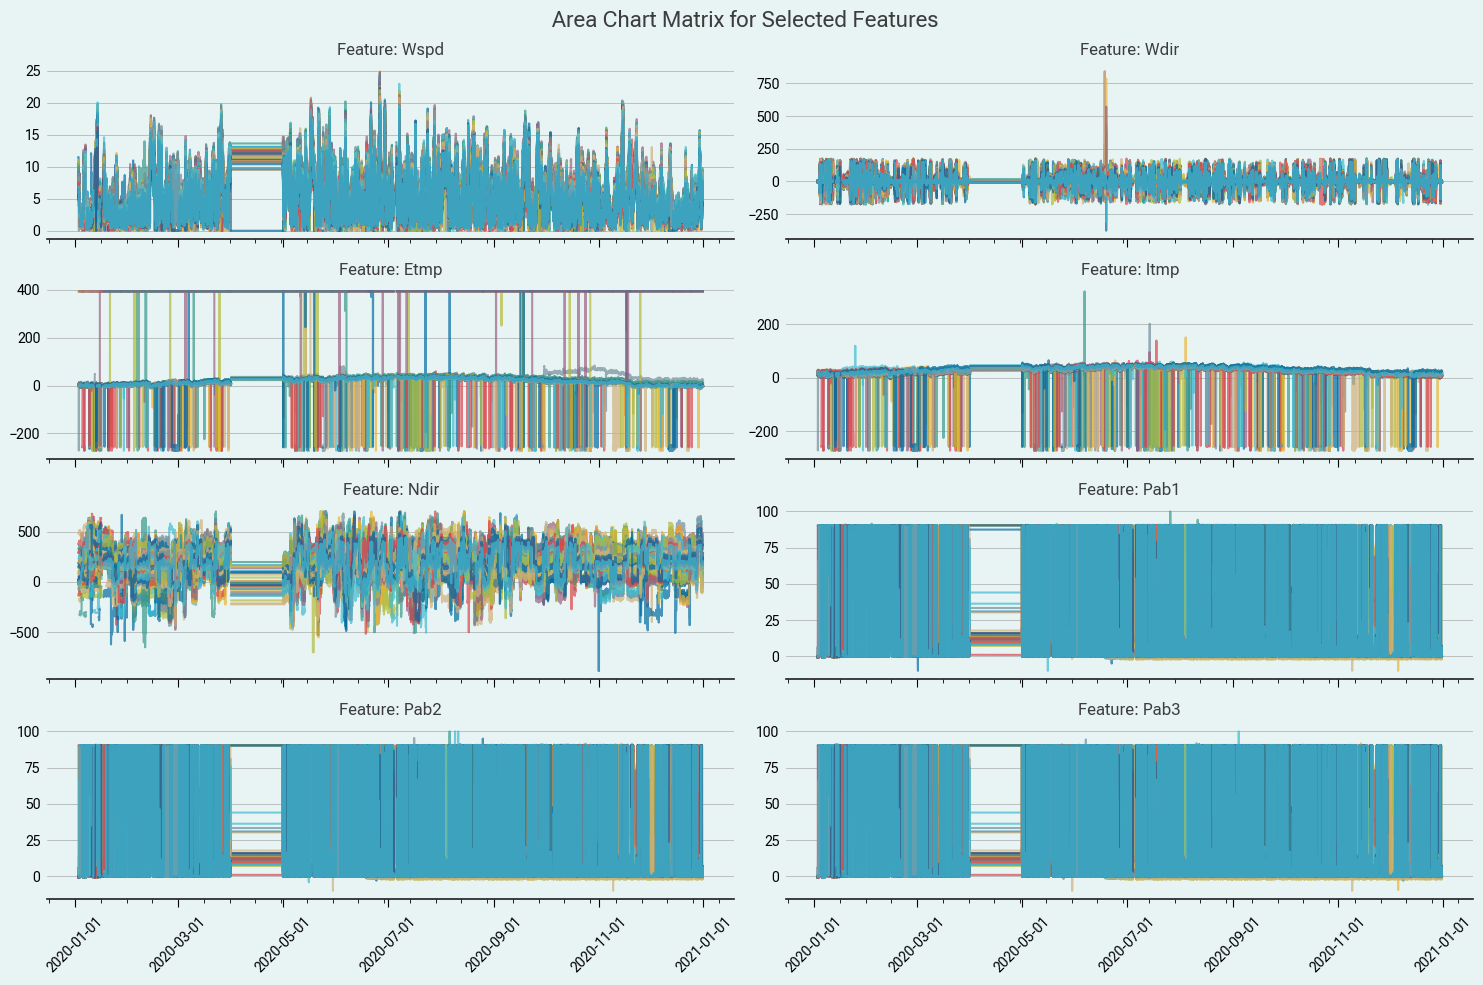

In [21]:
col_plot = list(df.columns)
col_plot.remove("TurbID")
create_plots_matrix(df, col_plot[:int(len(df.columns)/2)], df["TurbID"].unique()[:66], 2, (15, 10))

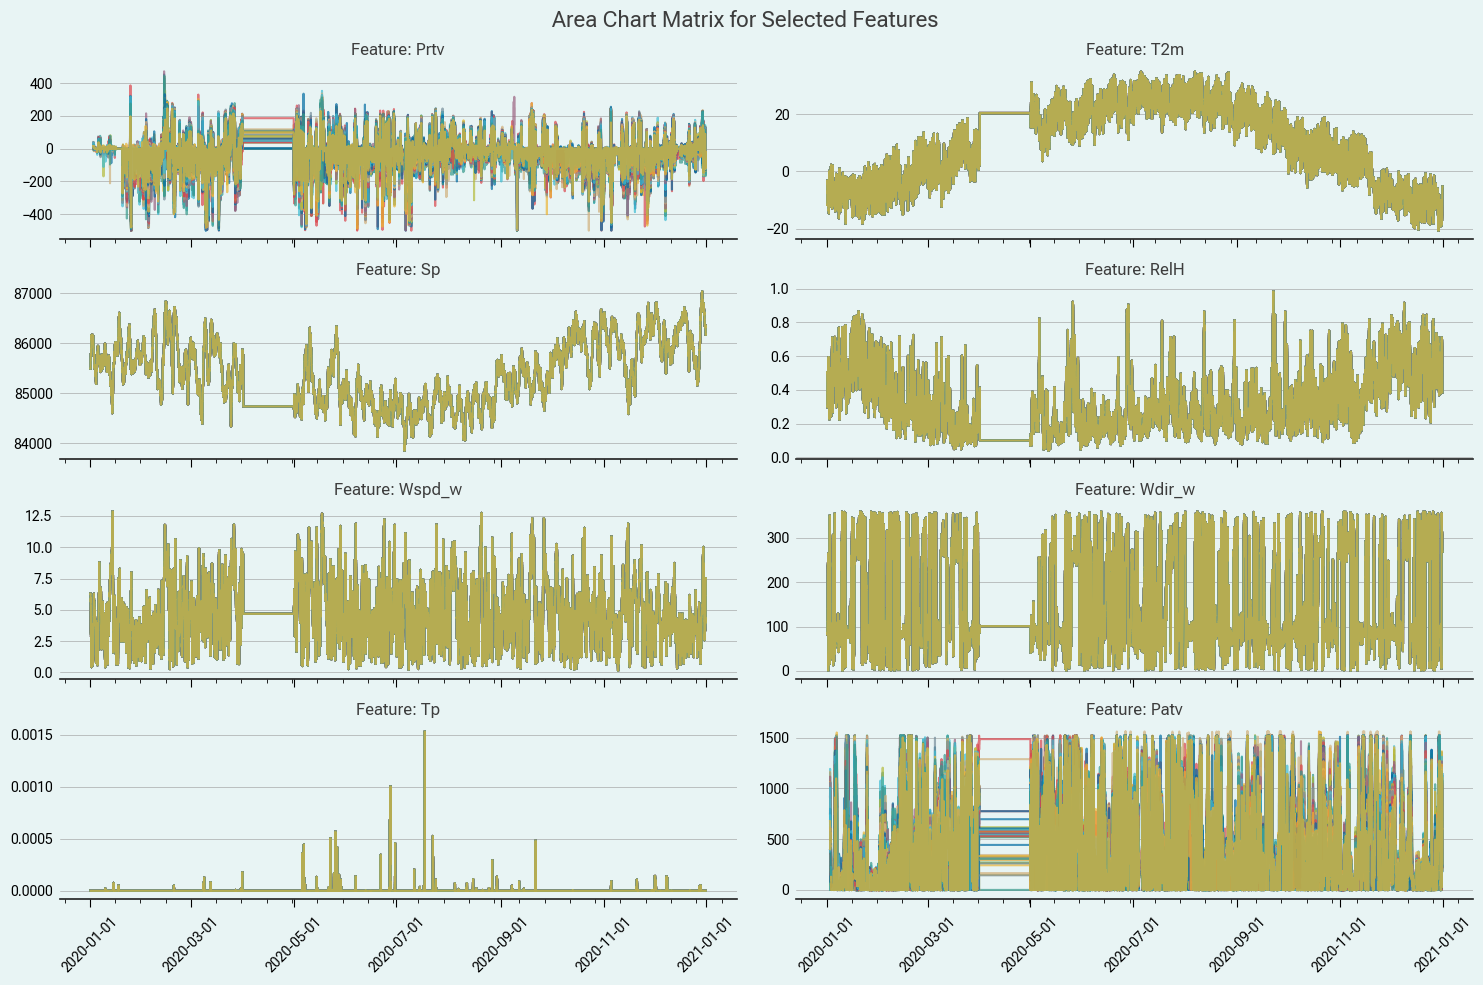

In [23]:
create_plots_matrix(df, col_plot[int(len(df.columns)/2):], df["TurbID"].unique()[66:], 2, (15, 10))

In [8]:
def plot_multiple_ts(df, feature, turbines_subset, figsize, window=None):
    mt.set_theme('ft')

    df_subset = df[df["TurbID"].isin(turbines_subset)].copy()
    df_subset = df_subset.sort_index()
    fig, ax = plt.subplots(figsize=figsize)

    if window:
        df_subset[feature+"_ra"] = df_subset[feature].rolling(window=window).mean()

    for turbine in turbines_subset:

        filtered_df = df_subset[df_subset["TurbID"]==turbine].sort_index()

        ax.plot(filtered_df.index, 
                 filtered_df[feature+"_ra"] if window else filtered_df[feature],
                 linewidth=1.5,
                 alpha=0.7)
        
    ax.set_title(f'Time series of feature {feature} for a subset of {len(turbines_subset)} turbines with MA smoothing')

    text = f'rolling window size: {window}' if window else "No smoothing applied."
    props = dict(boxstyle="round,pad=0.3", facecolor="lightgrey", edgecolor="black", alpha=0.7)

    ax.text(
        0.02, 0.95, text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props
    )

    plt.tight_layout()
    plt.show()

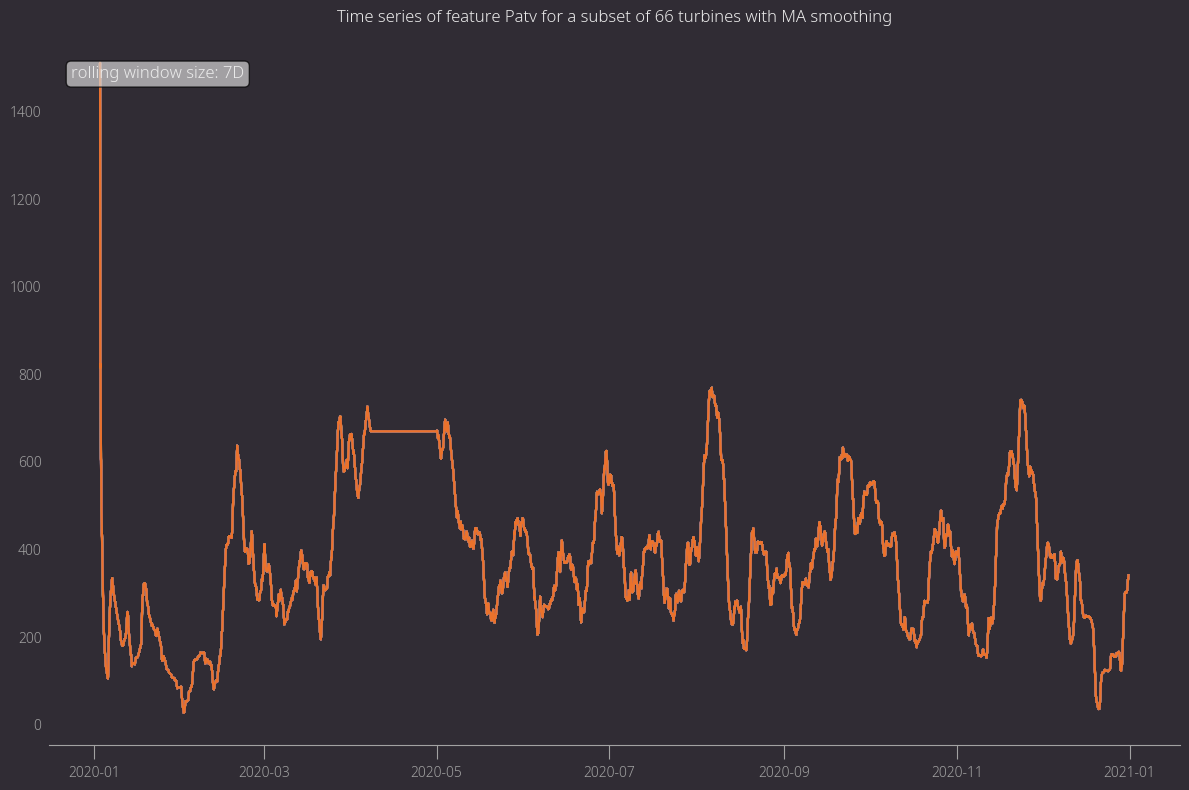

In [9]:
plot_multiple_ts(df, "Patv", df["TurbID"].unique()[:66], (12, 8), "7D")

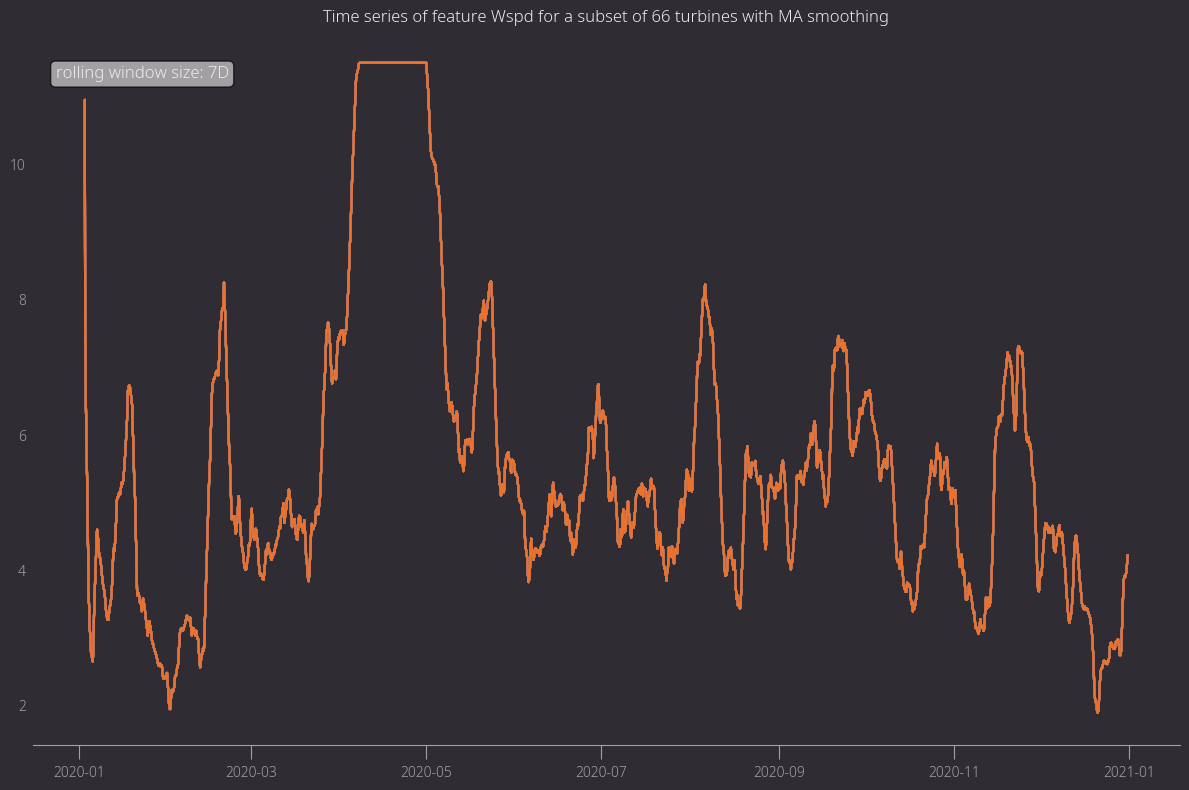

In [10]:
plot_multiple_ts(df, "Wspd", df["TurbID"].unique()[:66], (12, 8), "7D")

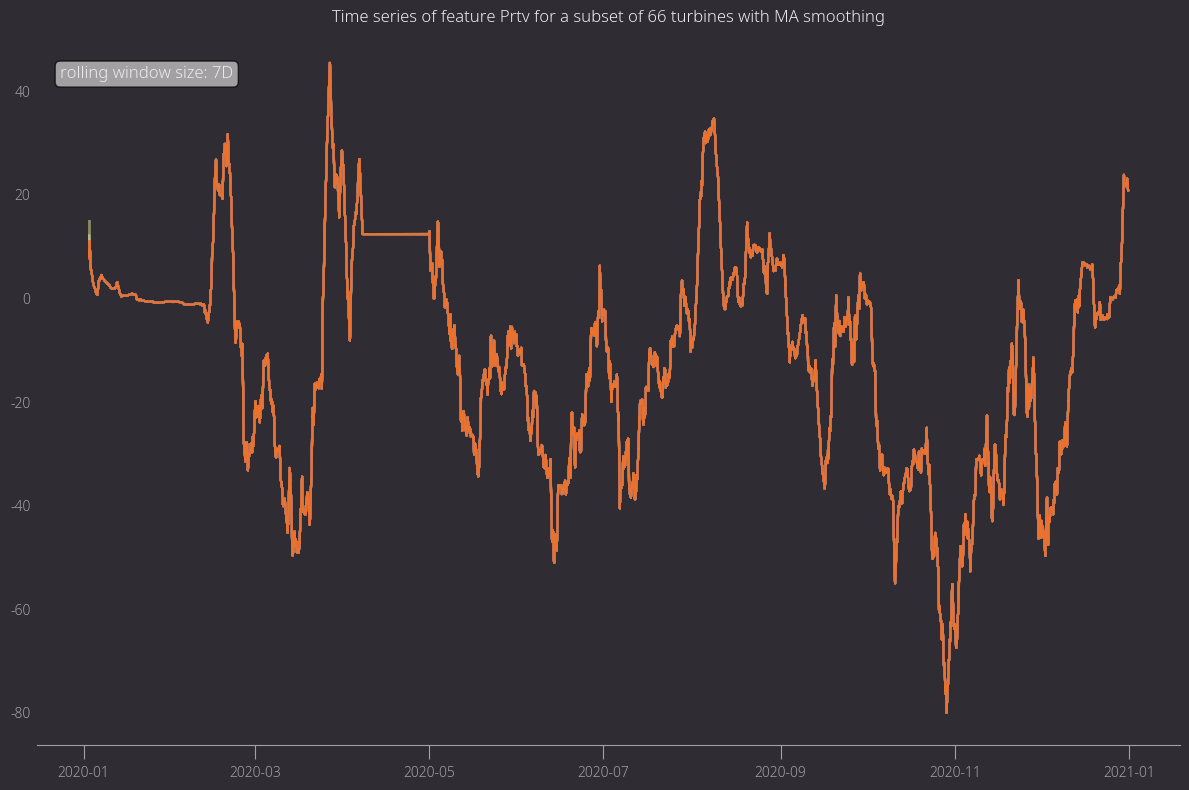

In [11]:
plot_multiple_ts(df, "Prtv", df["TurbID"].unique()[:66], (12, 8), "7D")

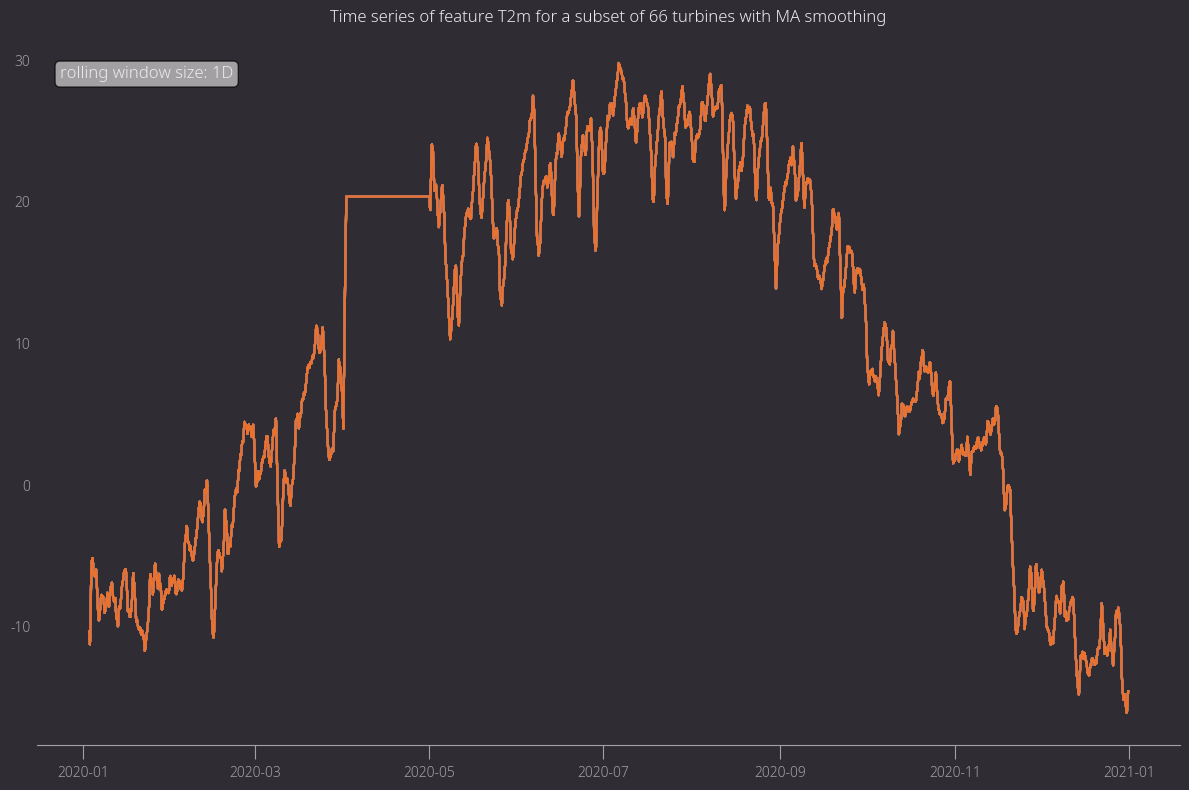

In [16]:
plot_multiple_ts(df, "T2m", df["TurbID"].unique()[:66], (12, 8), "1D")

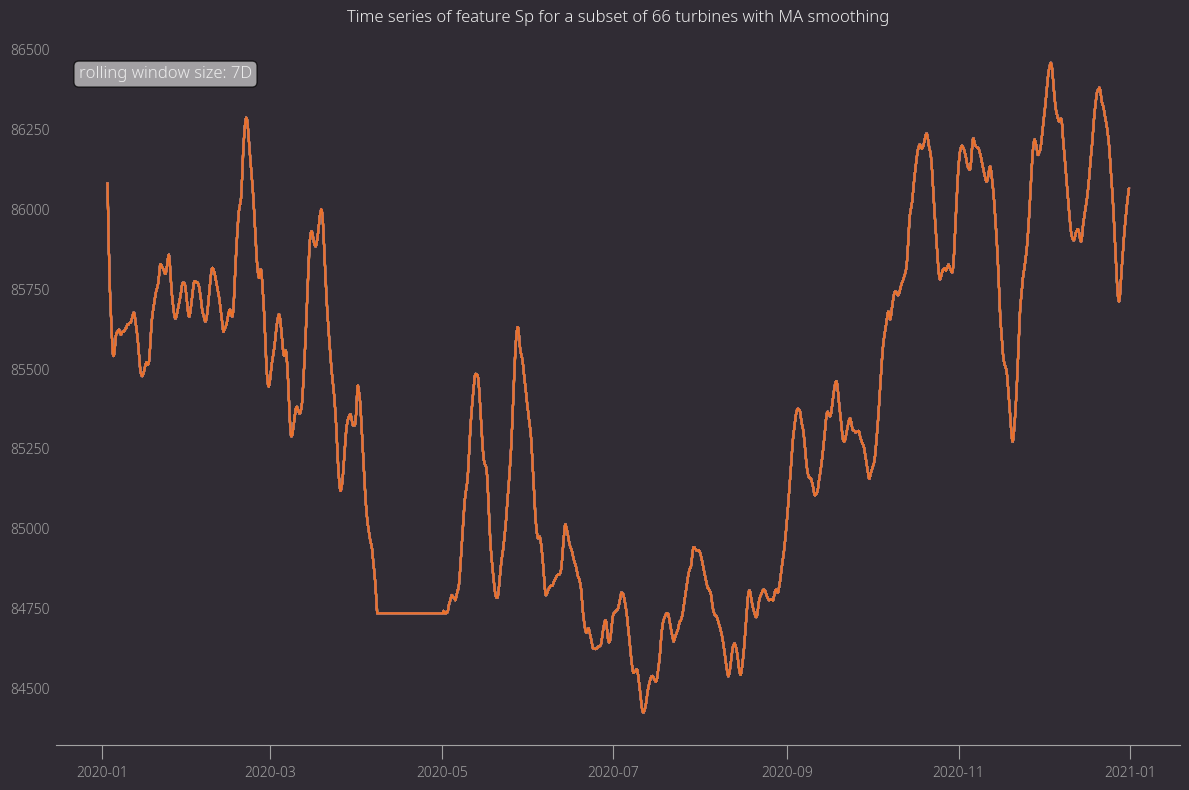

In [17]:
plot_multiple_ts(df, "Sp", df["TurbID"].unique()[:66], (12, 8), "7D")

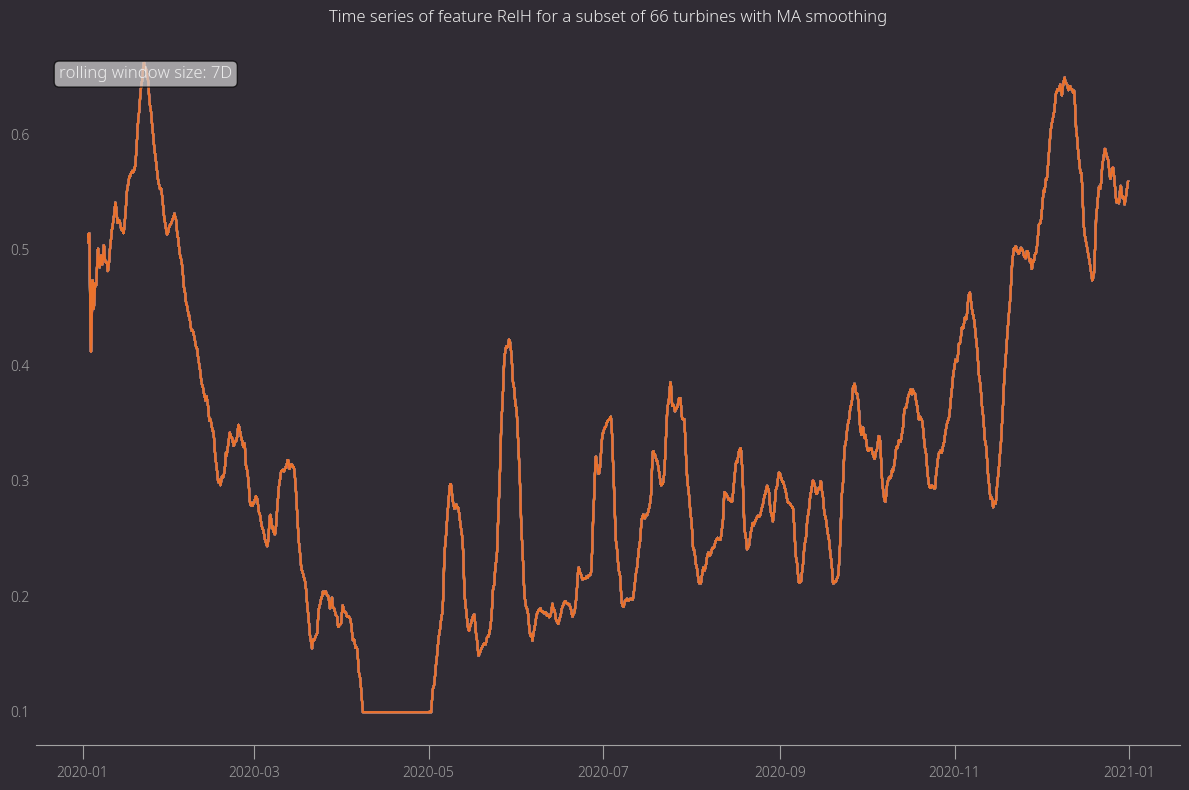

In [18]:
plot_multiple_ts(df, "RelH", df["TurbID"].unique()[:66], (12, 8), "7D")

### Sanity checks

In [24]:
def boxplot_ts(df, feature, turbines_subset, figsize):
    # mt.set_theme('ft')
    df_subset = df[df["TurbID"].isin(turbines_subset)].copy()
    df_subset = df_subset.sort_index()
    df_subset = df_subset[df_subset.index>=pd.to_datetime("2020-01-03 00:00:00")]
    fig, ax = plt.subplots(figsize=figsize)

    # List of series
    data_boxplot = [df_subset[df_subset["TurbID"]==turbine][feature] for turbine in turbines_subset]
    ax.boxplot(data_boxplot, tick_labels=turbines_subset)
    ax.set_title(f'Boxplot of selected features for feature {feature}')

    plt.tight_layout()
    plt.show()

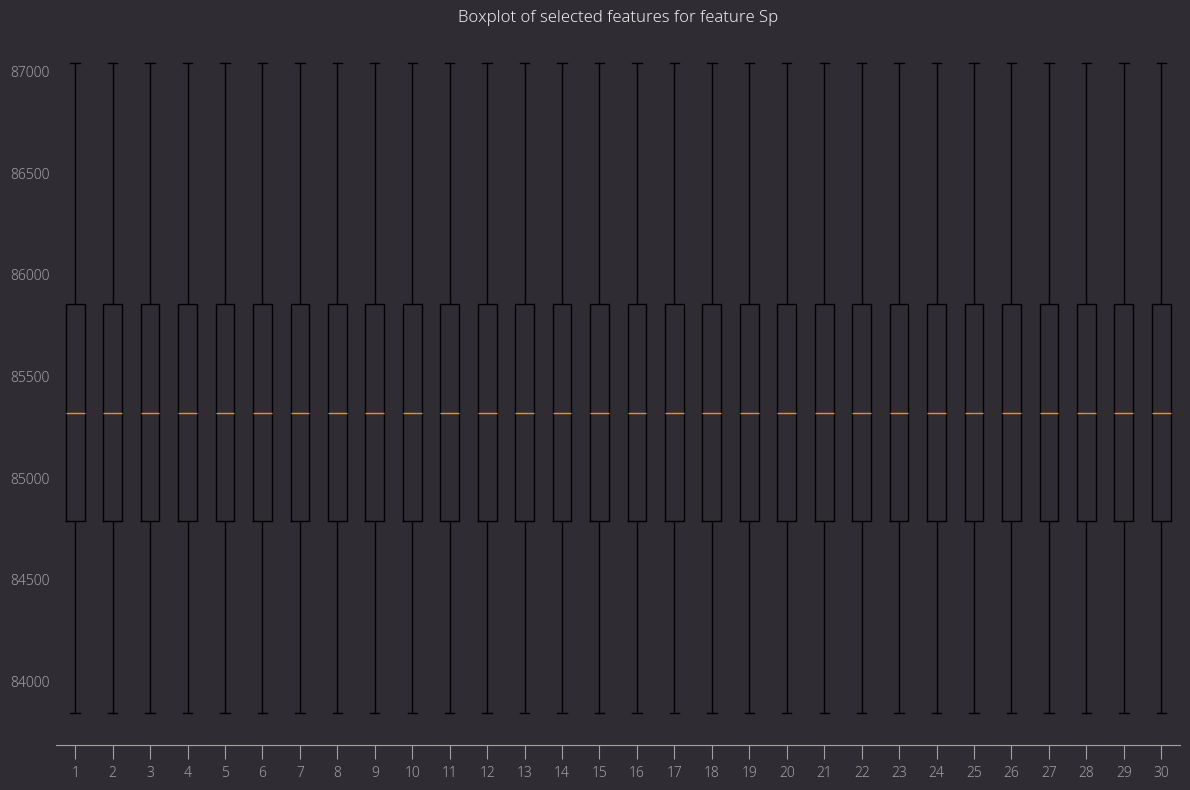

In [25]:
import random
features_boxplot = list(df.columns)
features_boxplot.remove("TurbID")
boxplot_ts(df, "Sp", df["TurbID"].unique()[:30], (12, 8))

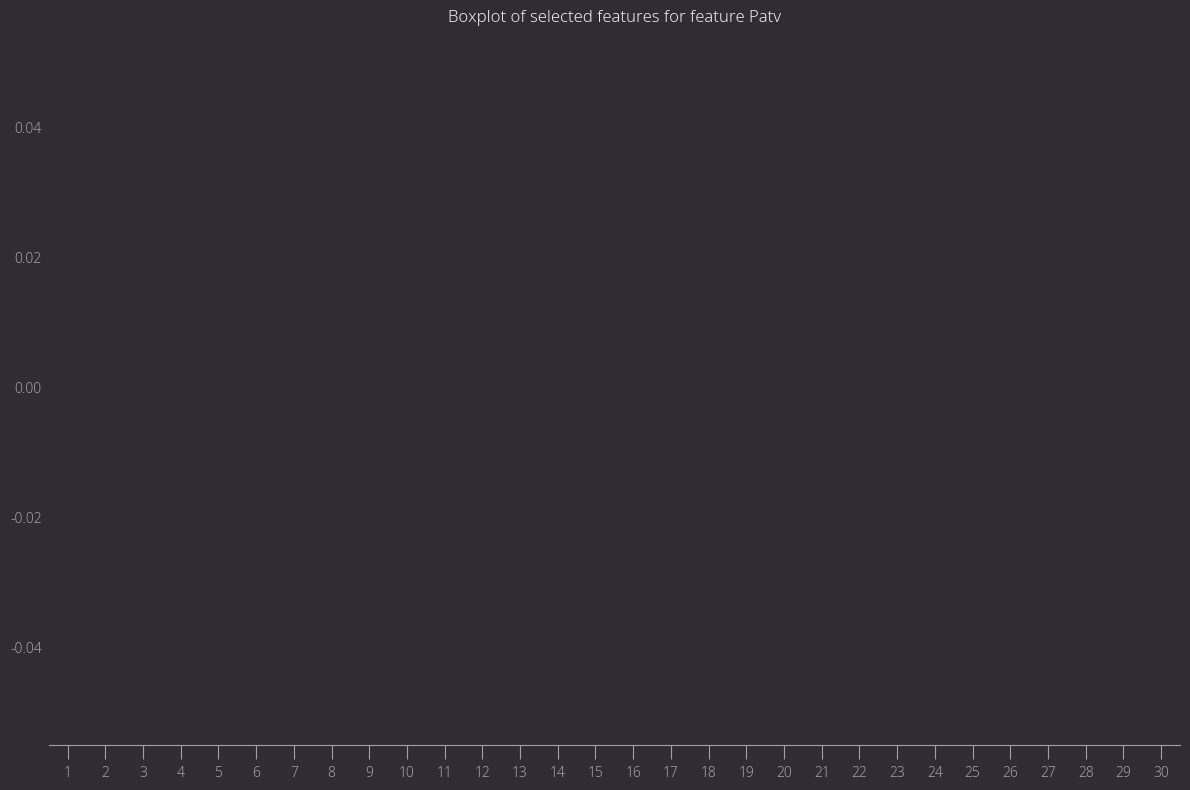

In [36]:
boxplot_ts(df, "Patv", df["TurbID"].unique()[:30], (12, 8))

In [32]:
df[df["TurbID"]==1]["Patv"]

2020-01-03 00:00:00    1503.050
2020-01-03 00:10:00    1503.050
2020-01-03 00:20:00    1503.050
2020-01-03 00:30:00    1336.245
2020-01-03 00:40:00    1336.245
                         ...   
2020-12-31 15:10:00     236.855
2020-12-31 15:20:00     236.855
2020-12-31 15:30:00     172.090
2020-12-31 15:40:00     172.090
2020-12-31 15:50:00     172.090
Name: Patv, Length: 52368, dtype: float64

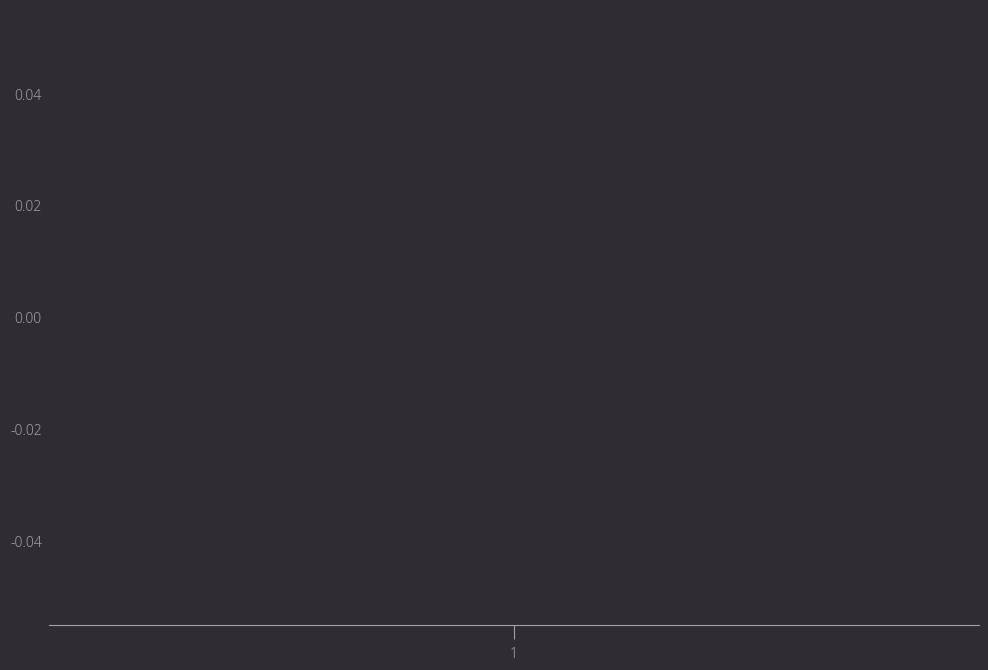

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
data_plot = df[df["TurbID"]==1]["Patv"]
ax.boxplot(data_plot.values)
plt.show()

### Implementation test MD-Linear

In [ ]:
class MovingAvg(nn.Module):
    def __init__(self, 
                 kernel_size,
                 stride):
        super().__init__()
        self.kernel_size = kernel_size
        self.averaging = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # Shape : [Batch dim, seq len, channels]
        # x[:, 0, :] would remove first dim
        # if len(x.shape) == 2:
        #     x = x.unsqueeze(0)
        
        #Repeated padding to avoid edge effects during mean computation
        front_val = x[:, 0:1, :].repeat(1, (self.kernel_size-1)//2, 1)
        end_val = x[:, -1:, :].repeat(1, (self.kernel_size-1)//2, 1)
        x = torch.concat([front_val, x, end_val], dim=1)
        # AvgPool1d work with (N: batch size, C: Channels, L: len of signal seq)
        x = self.averaging(x.permute((0, 2, 1)))
        # We need to repermute to (batch size, seq len, channels)
        x = x.permute(0, 2, 1)
        return x

class TsDecomposition(nn.Module):
    def __init__(self, kernel_size,
                 stride):
        super().__init__()
        self.moving_avg = MovingAvg(kernel_size=kernel_size, stride=stride)
    
    def forward(self, x):
        mvg_avg = self.moving_avg(x)
        residuals = x - mvg_avg
        return mvg_avg, residuals
    
class Dlinear(nn.Module):
    def __init__(self, n_features, seq_len, fcst_len, kernel_size, stride):
        super().__init__()
        self.ts_decomp = TsDecomposition(kernel_size=kernel_size, stride=stride)
        self.seq_len = seq_len
        self.fcst_len = fcst_len
        self.n_features = n_features

        self.LinearTrend = nn.ModuleList()
        self.LinearSeasonal = nn.ModuleList()

        for channel in range(self.n_features):
            self.LinearTrend.append(nn.Linear(seq_len, fcst_len))
            self.LinearTrend[channel].weight = nn.Parameter((1/self.seq_len) * torch.ones([self.fcst_len, self.seq_len]))
            self.LinearSeasonal.append(nn.Linear(seq_len, fcst_len))
            self.LinearSeasonal[channel].weight = nn.Parameter((1/self.seq_len) * torch.ones([self.fcst_len, self.seq_len]))

        self.LinearPred = nn.Linear(self.n_features, 1)
        self.LinearPred.weight = nn.Parameter((1/self.seq_len) * torch.ones([1, self.n_features]))
    
    def forward(self, x):
        trend_comp, seasonal_comp = self.ts_decomp(x) #[Batch, seq len, channels]
        trend_comp, seasonal_comp = trend_comp.permute(0, 2, 1), seasonal_comp.permute(0, 2, 1) # [Batch, channels, seq len]

        # Initializing output tensors [Batch, Channels, fcst len]
        trend_output = torch.zeros([trend_comp.shape[0], self.n_features, self.fcst_len], dtype=trend_comp.dtype)
        seasonal_output = torch.zeros([seasonal_comp.shape[0], self.n_features, self.fcst_len], dtype=trend_comp.dtype)

        for i in range(self.n_features):
            trend_output[:, i, :] = self.LinearTrend[i](trend_comp[:, i, :]) # input of the layer is [Batch, Seq Len]
            seasonal_output[:, i, :] = self.LinearSeasonal[i](seasonal_comp[:, i, :])
        
        output = trend_output + seasonal_output
        output = output.permute(0, 2, 1) # [Batch, fcst len, channels]
        output = self.LinearPred(output) # Merge all features fcst
        return output


In [ ]:
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler

class DatasetCustom(Dataset):
    def __init__(self, seq_len: int, pred_len:int, run_type: str):
        super().__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        map_run_type = {"train": 0, "val": 1, "test": 2}
        self.run_type = map_run_type[run_type]
        print(self.run_type)
        self.__load_data__()

    def __load_data__(self):
        df = pd.read_csv("/workspaces/ds_project_1/data/sdwpf_2001_2112_full.csv", nrows=3000000)

        # set index, sort values
        df["Tmstamp"] = pd.to_datetime(df["Tmstamp"])
        df.sort_values(by=["TurbID", "Tmstamp"], inplace=True)
        df.set_index("Tmstamp", inplace=True)

        # Reindex all turbines for same length
        date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="10min")
        df = df.groupby("TurbID").apply(lambda x: x.reindex(date_range, method="bfill"))
        df.reset_index(level="TurbID", drop=True, inplace=True) #Drop multiple index

        # Drop values before first valid index
        df = df[~(df.index<pd.to_datetime("2020-01-03 00:00:00"))]

        # Remove incorrect or unknown values
        nan_rows = df.isnull().any(axis=1)
        invalid_cond = (df['Patv'] < 0) | \
                    ((df['Patv'] == 0) & (df['Wspd'] > 2.5)) | \
                    ((df['Pab1'] > 89) | (df['Pab2'] > 89) | (df['Pab3'] > 89)) | \
                    ((df['Wdir'] < -180) | (df['Wdir'] > 180) | (df['Ndir'] < -720) |
                        (df['Ndir'] > 720))
        # 
        df.loc[invalid_cond, list(set(df.columns)).remove("TurbID")] = np.nan

        self.mask = np.where(invalid_cond | nan_rows, 0, 1)

        # Handle power features less than 0
        df.loc[df['Patv'] < 0, 'Patv'] = 0
        df['Prtv'] = df['Prtv'].abs()


        # Rearrange columns with target at the end
        new_cols = [col for col in df.columns.to_list() if col not in ["Patv"]]
        new_cols.append("Patv")
        df = df.reindex(columns=new_cols)

        df = df.groupby('TurbID').apply(lambda x: x.interpolate().ffill().bfill().fillna(0))
        df.reset_index(level="TurbID", drop=True, inplace=True) #Drop multiple index
                                         
        train_end_index = int(np.ceil(len(df)*0.9)) #End of the train split

        # Split each turbines dataset separately to avoid data leakage
        if self.run_type == 0:
            turbine_groups = df.groupby("TurbID")
            dfs = []
            for _, group in turbine_groups:
                train_end_index = int(np.ceil(len(group)*0.9))
                if self.run_type == 0:
                    dfs.append(group.iloc[:train_end_index])
                else:
                    dfs.append(group.iloc[train_end_index:])

            df = pd.concat(dfs)

        # Scaling
        if self.run_type == 0:
            self.scaler = StandardScaler()
            # Fit on train data to prevent data leakage
            self.scaler.fit(df.drop(columns=["TurbID"]).values)
            scaled_data = self.scaler.transform(df.drop(columns=["TurbID"]).values)
        else: # if validation run
            scaled_data = self.scaler.transform(df.drop(columns=["TurbID"]).values)

        # num_features = df.drop(columns=["TurbID"]).shape[-1]

        self.predictors = scaled_data.reshape(len(df["TurbID"].unique()), -1, scaled_data.shape[-1])
        print(self.predictors.shape)
        self.target = scaled_data.reshape(len(df["TurbID"].unique()), -1, scaled_data.shape[-1])
        self.mask = self.mask.reshape(len(df["TurbID"].unique()), -1, 1)

    def __getitem__(self, index):

        turbine = index // (self.predictors.shape[1] - self.seq_len - self.pred_len + 1) # index turbine // total number of sliding window per turbines
        seq_start = index % (self.predictors.shape[1] - self.seq_len - self.pred_len + 1) # index mod total number of sliding window 

        target_start = seq_start + self.seq_len
        target_end = target_start + self.pred_len

        preds_seq = self.predictors[turbine][seq_start:seq_start+self.seq_len]
        target_seq = self.target[turbine][target_start:target_end]
        mask = self.mask[turbine][target_start:target_end]

        return preds_seq, target_seq, mask
    
    def __len__(self):
        # Total number of samples is (number of turbines) * (number of time steps - sliding window length - prediction horizon)
        # We have to substract sliding window length and prediction horizon, so the last index used has a start for the sliding window
        # is considering the length of sliding window and the pred horizon.
        # Hence the second term is the possible number of sliding window per turbine.
        total_samples = self.predictors.shape[0] * (self.predictors.shape[1] - self.seq_len - self.pred_len + 1)
        return total_samples

In [ ]:
class MSELoss(nn.Module):
    def __init__(self):
        super(MSELoss, self).__init__()
    
    def forward(self, pred, target):
        return torch.sqrt(torch.mean(torch.pow((pred - target), 2)))

class MAELoss(nn.Module):
    def __init__(self):
        super(MAELoss, self).__init__()
    
    def forward(self, pred, target):
        return torch.mean(torch.abs(pred - target))

class CustomLoss(nn.Module):
    def __init__(self, fcst_len):
        super().__init__()
        self.mse_loss = nn.MSELoss()
        self.mae_loss = nn.L1Loss()
        self.fcst_len = fcst_len

    def forward(self, pred, target, mask):
        mask = mask[:, -self.fcst_len:, :] 
        pred = pred[:, -self.fcst_len:, -1:]*mask # -1: instead of -1 to avoid losing a dimension
        target = target[:, -self.fcst_len:, -1:]*mask #select last columns which is power from dataset construction
        mse = self.mse_loss(pred, target)
        mae = self.mae_loss(pred, target)
        return mse + mae


In [ ]:
import time
from torch.utils.data import DataLoader
from tqdm import tqdm
epochs = 1
model = Dlinear(n_features=16, seq_len=50, fcst_len=72, kernel_size=25, stride=1)
dataset = DatasetCustom(50, 72, "train")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = CustomLoss(fcst_len=72)
dataloader = DataLoader(dataset=dataset, batch_size=32, drop_last=True, shuffle=True)

for epoch in range(epochs):
    train_loss, train_loss_part = [], []
    epoch_time = time.time()
    model.train()

    for i, (batch_x, batch_y, mask) in enumerate(tqdm(dataloader, desc=f"epoch{epoch+1}", unit="batch")):
        optimizer.zero_grad() # zeros out all partial derivatives
        batch_x = torch.tensor(batch_x, dtype=torch.float)
        batch_y = torch.tensor(batch_y, dtype=torch.float)
        mask = torch.tensor(mask, dtype=torch.float)
        # Compute preds with the net
        preds = model(batch_x)

        # Compute loss for this batch
        loss = loss_func(preds, batch_y, mask)
        train_loss_part.append(loss.item()) #.item() only work for scalar tensor

        # Compute partial derivatives of the loss w.r.t to weights using reverse auto-diff via Pytorch autograd
        loss.backward()
        # Updates parameters using gradients
        optimizer.step()
        if (i+1)%10000==0:
            print("\titers: {0}, epoch: {1}".format(i + 1, epoch + 1))
            print(f"\ttrain loss part: {np.average(train_loss_part)}")
            train_loss.extend(train_loss_part)
            train_loss_part = []
    
    train_loss.extend(train_loss_part)
    # Average for whole epoch
    train_loss = np.average(train_loss)
    print(train_loss)
    
    print(f"Epoch: {epoch + 1} | Cost time: {time.time() - epoch_time}")
    print(f"Epoch: {epoch + 1} | Train Loss: {train_loss}")
    


0


/tmp/ipykernel_720/4089919858.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("TurbID").apply(lambda x: x.reindex(date_range, method="bfill"))
/tmp/ipykernel_720/4089919858.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('TurbID').apply(lambda x: x.interpolate().ffill().bfill().fillna(0))


(134, 47132, 17)


epoch1:   0%|          | 0/196858 [00:00<?, ?batch/s]/tmp/ipykernel_720/2702186049.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_x = torch.tensor(batch_x, dtype=torch.float)
/tmp/ipykernel_720/2702186049.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_y = torch.tensor(batch_y, dtype=torch.float)
/tmp/ipykernel_720/2702186049.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float)
epoch1:   4%|▍         | 8565/196858 [04:39<1:37:33, 32.17batch/s]